# Credit Card Fraud Detection

Dataset: https://www.kaggle.com/datasets/whenamancodes/fraud-detection

The goal for this note book is to take the data set above and train a pytorch neural network to accuratly detect credit card fraud.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

### Load File

In [2]:
file = "creditcard.csv"
df = pd.read_csv(file)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The time column for this dataset is related to seconds passed since the first transaction. This has no relation to a fraud metric and can be dropped.

In [3]:
df.drop(["Time"],axis=1, inplace=True)
df.shape

(284807, 30)

# Data Exploration

Check for nan vales

In [4]:
df.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

In [6]:
print(f"Number of legitimate cases: {len(df[df['Class'] == 0])}")
print(f"Number of fraudulent cases: {len(df[df['Class'] == 1])}")

Number of legitimate cases: 284315
Number of fraudulent cases: 492


Here we can see the massive disproportion in the data target class.

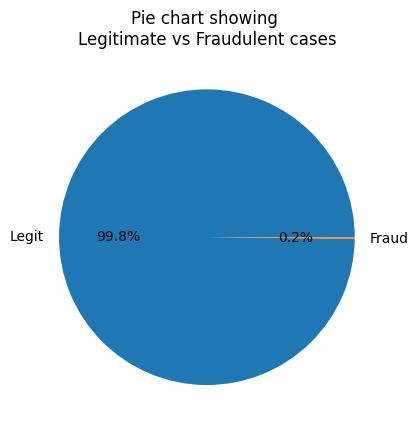

In [7]:
labels = ["Legit","Fraud"]
values = [len(df[df['Class'] == 0]), len(df[df['Class'] == 1])]
plt.title("Pie chart showing \nLegitimate vs Fraudulent cases")
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.show()

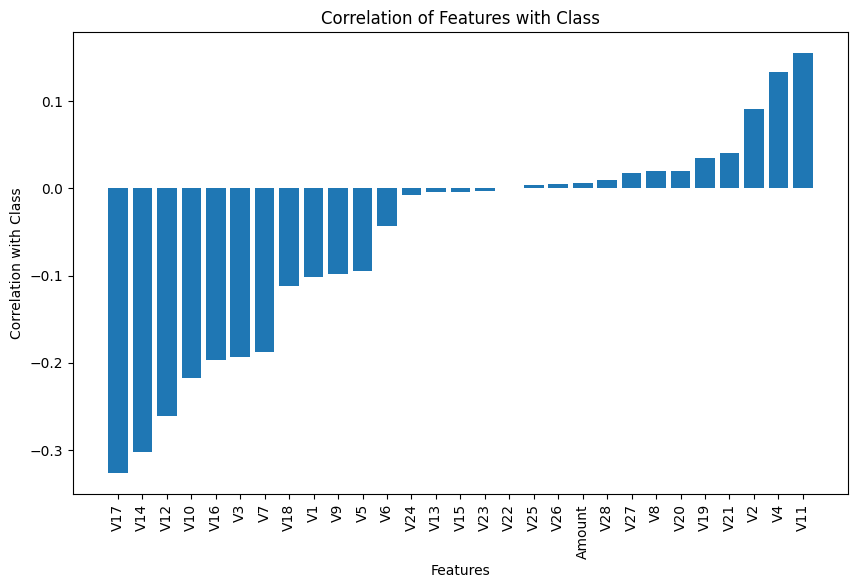

In [8]:
corr = df.corr()["Class"][:-1].sort_values()
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(corr.index, corr.values)
plt.xlabel('Features')
plt.ylabel('Correlation with Class')
plt.title('Correlation of Features with Class')
plt.xticks(rotation=90)
plt.show()

In [9]:
important = df.corr()["Class"][:-1].abs() > 0.1
print(important.sort_values())

V15       False
V27       False
V26       False
V25       False
V24       False
V23       False
V22       False
V21       False
V20       False
V19       False
V28       False
V13       False
Amount    False
V9        False
V8        False
V6        False
V5        False
V2        False
V14        True
V11        True
V16        True
V17        True
V18        True
V10        True
V7         True
V4         True
V3         True
V12        True
V1         True
Name: Class, dtype: bool


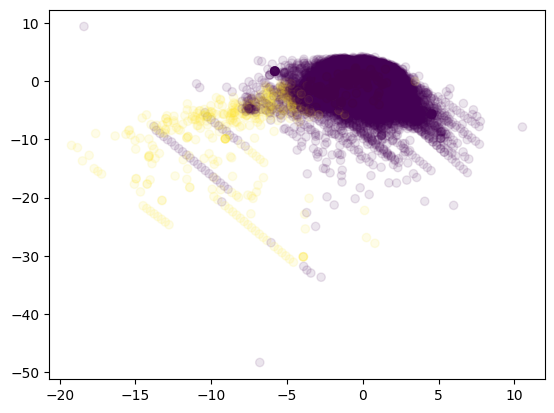

In [10]:
plt.scatter(x=df["V14"], y=df["V3"], c=df["Class"],alpha=0.1)
plt.show()

A standard matplotlib scatter plot will not suffice here as the data is too tightly packed to show the distribution. Instead I will use a seaborns joint plots.

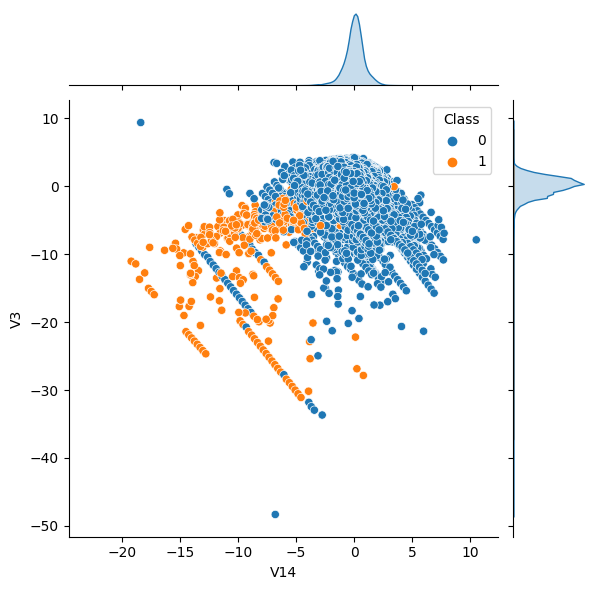

In [11]:
sns.jointplot(x='V14', y='V3',hue='Class', data=df)
plt.show()

Here we can clearly see that these "important" features are seperating the two classes quite well but they are still intermingled in most cases.

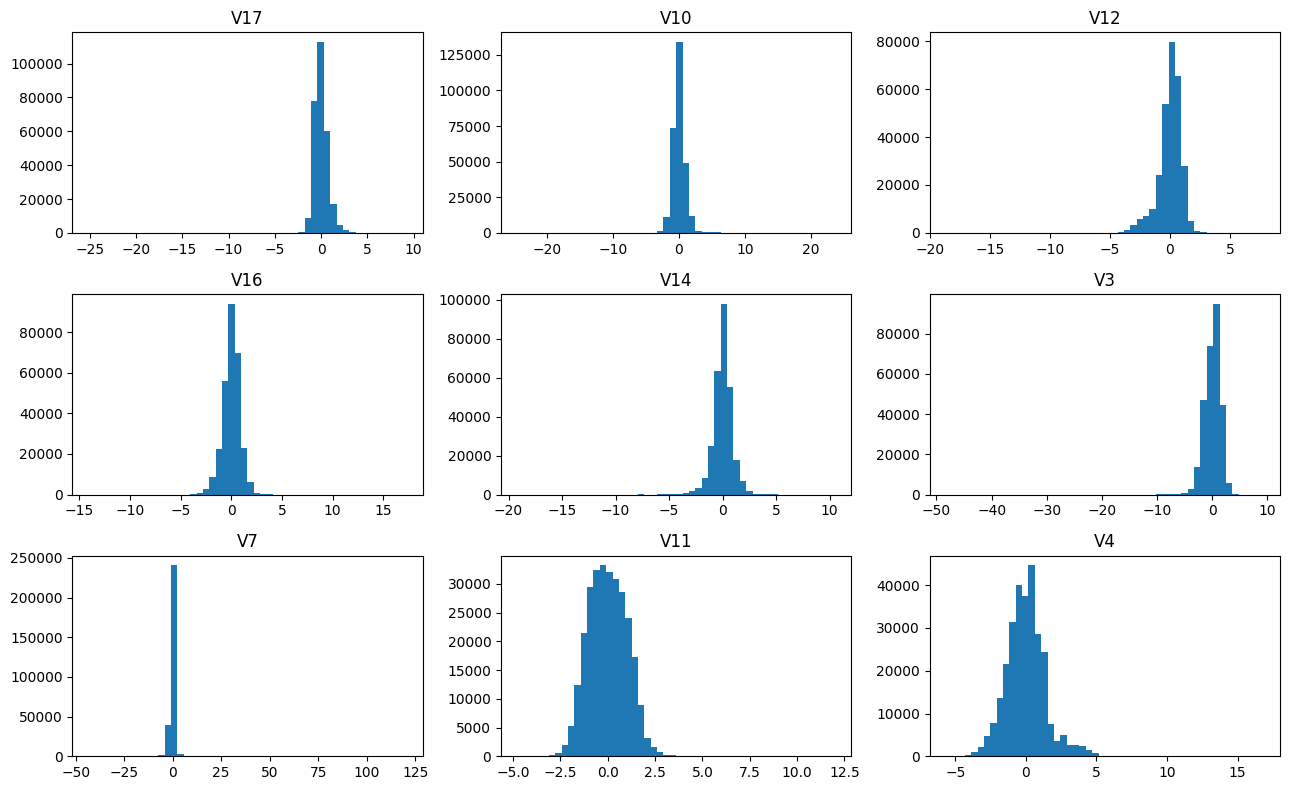

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 8))
columns = ['V17', 'V10', 'V12', 'V16', 'V14', 'V3', 'V7', 'V11', 'V4']
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        axes[i, j].hist(df[columns[index]], bins=50, linewidth=0.5)
        axes[i, j].set_title(f"{columns[index]}")

plt.tight_layout()
plt.show()

### Removing outliers

In [13]:
def outliers(df,n,features):
    outliers = []
    
    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        
        IQR = Q3 - Q1
        
        outlier_step = 1.5 *IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        outliers.extend(outlier_list_col)
    outliers = Counter(outliers)        
    multiple_outliers = list( k for k, v in outliers.items() if v > n )
    
    return multiple_outliers   
Outliers_IQR = outliers(df,2,['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])

In [14]:
#Df made of outliers
df_out = df.loc[df.index[Outliers_IQR]]
print(f"Number of legitimate cases: {len(df_out[df_out['Class'] == 0])}")
print(f"Number of fraudulent cases: {len(df_out[df_out['Class'] == 1])}")
df_out.shape

Number of legitimate cases: 46667
Number of fraudulent cases: 449


(47116, 30)

In [15]:
#Df with outliers removed
df_in = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)
print(f"Number of legitimate cases: {len(df_in[df_in['Class'] == 0])}")
print(f"Number of fraudulent cases: {len(df_in[df_in['Class'] == 1])}")
df_in.shape

Number of legitimate cases: 237648
Number of fraudulent cases: 43


(237691, 30)

Quick check that both of the dataframes combined equal the original dataframe.

In [16]:
df_in.shape[0] + df_out.shape[0] == df.shape[0]

True

# Time to make and train a PyTorch model

First set the device

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Data Splitting and DataLoaders

In [18]:
data = df_out.values
X = data[:,:-1]
y = data[:, -1]
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 *len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size =128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define the model

In [19]:
model = nn.Sequential(
    nn.Linear(X.shape[1], 20),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(20,10),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(10,2)
)
model.to(device)

Sequential(
  (0): Linear(in_features=29, out_features=20, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=20, out_features=10, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=10, out_features=2, bias=True)
)

In [20]:
loss_fn= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Training loop

In [21]:
def train(model, num_epochs, train_dataloader, val_dataloader, optimizer, loss_fn, device):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_val = [0] * num_epochs
    accuracy_hist_val = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train() #Set the model to train mode
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device) #Move the data to the device
            
            optimizer.zero_grad()
            
            pred = model(x_batch)
            
            #print(f"Epoch {epoch+1}, Batch: y_batch type: {y_batch.dtype}, pred typ: {pred.dtype}")
            
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        
        loss_hist_train[epoch] /= len(train_dataloader.dataset)
        accuracy_hist_train[epoch] /= len(train_dataloader.dataset)
        
        model.eval() #Set the model to eval mode
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device) #move to device
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_val[epoch] += loss.item()* y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_val[epoch] += is_correct.sum()
            
            loss_hist_val[epoch] /= len(val_dataloader.dataset)
            accuracy_hist_val[epoch] /= len(val_dataloader.dataset)
        
        print(f"Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_val[epoch]:.4f}")
    
    return loss_hist_train, loss_hist_val, accuracy_hist_train, accuracy_hist_val

In [22]:
torch.manual_seed(1)
num_epochs=5
hist = train(model, num_epochs, train_dataloader, val_dataloader, optimizer, loss_fn, device)

Epoch 1 accuracy: 0.9881 val_accuracy: 0.9911
Epoch 2 accuracy: 0.9914 val_accuracy: 0.9901
Epoch 3 accuracy: 0.9915 val_accuracy: 0.9932
Epoch 4 accuracy: 0.9916 val_accuracy: 0.9901
Epoch 5 accuracy: 0.9919 val_accuracy: 0.9918


In [55]:
def get_predictions(model, dataloader, device, threshold):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            probs = torch.softmax(preds,dim=1)[:,1]
            all_preds.append((probs > threshold).long().cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds

# Get predictions and true labels
threshold = 0.01 #Alter this variable to change the classification threshold
true_labels, predictions = get_predictions(model, test_dataloader, device, threshold)

In [56]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix

array([[6629,  370],
       [  10,   59]], dtype=int64)

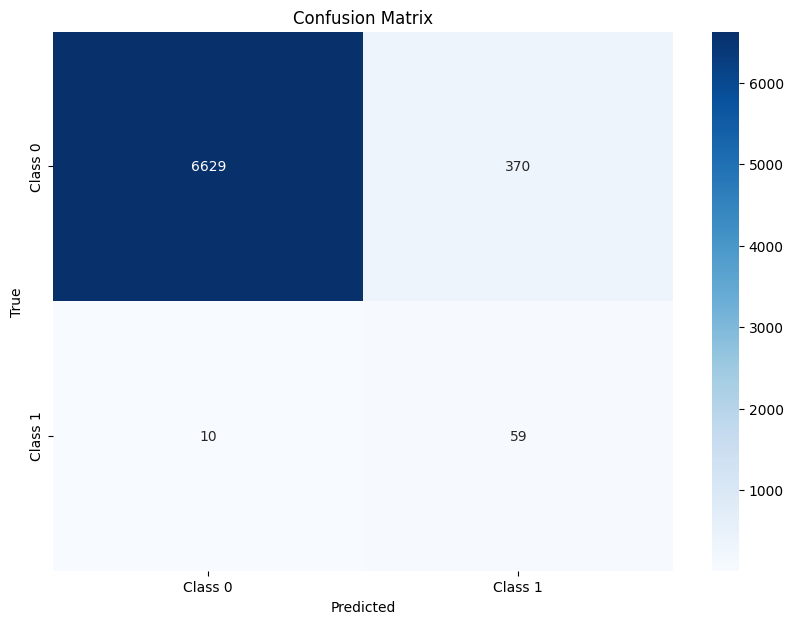

In [57]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have class names in a list called class_names
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names
plot_confusion_matrix(conf_matrix, class_names)


The threshold variable is to allow to the tuning of false negatives and positives. The exact numbers for these stats could be decided and altered on the fly now. Allowing for whichever persons job it would in this hypotherical scenario.

# Save the model

Just uncomment the below code to save the model

In [26]:
torch.save(model, 'model.pth')
#print("Model saved")

# Conclusion

Throughout this notebook, I loaded the dataset and identified the most important features regarding identifying the class target variable. I then removed any outliers in the data to make their own data frame to balance the class labels better to help the model understand their differences. Next, I trained a sequential model using PyTorch using ReLU activation layers to enable the understanding of non-linear data. To make the model more robust I also added some quite aggressive dropout layers with a setting of 0.5. Lastly, I plotted the confusion matrix for the model predictions on the test dataset. There is a variable to alter the threshold for the predictions to allow for a more favourable classification rate if needed. 